This notebook combines audio clips into 5-second WAV files and then spectrograms of those WAV files.  These spectrograms are saved together as a numpy array in pickle format.

Also saves a pickle of labels for each spectrogram.

Can be used to generate training and validation data.  

Is currently set up to register 3 classes: 'enough', 'not_enough', 'empty'.

### starting point:

- Assume a folder `recorded_clips`, with subfolders of audio clips:
    - `empties`
    - `enoughs`
    - `notenoughs`
    - `fullbackgrounds_trimmed_5sec`
    
- Can have any number of audio clips.  Only constraint is that the samples are all less than 5 seconds, and the background clips are all exactly 5 seconds.  (Can use `preprocess_audio` and `split_into_2_5sec_files` to turn 10+ second clips into 5 second clips.
- Assume folders `XY_train` and `XY_val`, where the training and validation data will go after generated.

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from mb_utils import *
%matplotlib inline

import pickle

/anaconda/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
Using TensorFlow backend.


In [2]:
from importlib import reload
import mb_utils

In [3]:
reload(mb_utils)
from mb_utils import *

In [4]:
Tx = 2754 #5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

#### Files to work with (may not have all background versions):

In `recorded_clips` folder, have subfolders:

- `backgrounds`: 10 short (1-2 sec) WAV files of background noise
- `enoughs`: 10 WAV files of 'enough', each roughly 1 sec
- `notenoughs`: 10 WAV files of 'not enough', in the 1-3 sec range
- `fullbackgrounds_original`: 10 long (10+ sec) WAV files of background noise
- `fullbackgrounds_trimmed_10sec`: same as original, but trimmed to 10 seconds using `preprocess_audio`
- `fullbackgrounds_trimmed_5sec`: takes ten 10 sec clips and splits them into twenty 5 second clips.

#### make 10+ sec background files into 5 second clips (don't do unless necessary)

In [197]:
def split_into_2_5sec_files(folder_name, idx):
    filename = 'recorded_clips/{}/{:0>2}.wav'.format(folder_name, idx)
    print(filename)
    padding1 = AudioSegment.silent(duration=5000)
    segment1 = AudioSegment.from_wav(filename)[:5000]
    segment1 = padding1.overlay(segment1)
    segment1 = segment1.set_frame_rate(44100)
    
    padding2 = AudioSegment.silent(duration=5000)
    segment2 = AudioSegment.from_wav(filename)[5000:]
    segment2 = padding2.overlay(segment2)
    segment2 = segment2.set_frame_rate(44100)
    
    # Export as wav
    segment1.export('recorded_clips/{}/{:0>2}.wav'.format(folder_name, idx), format='wav')
    segment2.export('recorded_clips/{}/{:1>2}.wav'.format(folder_name, idx), format='wav')

In [198]:
for i in range(10):
    #split_into_2_5sec_files('fullbackgrounds_trimmed_5sec', i)

recorded_clips/fullbackgrounds_trimmed_5sec/00.wav
recorded_clips/fullbackgrounds_trimmed_5sec/01.wav
recorded_clips/fullbackgrounds_trimmed_5sec/02.wav
recorded_clips/fullbackgrounds_trimmed_5sec/03.wav
recorded_clips/fullbackgrounds_trimmed_5sec/04.wav
recorded_clips/fullbackgrounds_trimmed_5sec/05.wav
recorded_clips/fullbackgrounds_trimmed_5sec/06.wav
recorded_clips/fullbackgrounds_trimmed_5sec/07.wav
recorded_clips/fullbackgrounds_trimmed_5sec/08.wav
recorded_clips/fullbackgrounds_trimmed_5sec/09.wav


In [5]:
def trim_to_5sec(folder_name, idx):
    filename = 'recorded_clips/{}/{:0>2}.wav'.format(folder_name, idx)
    print(filename)
    padding1 = AudioSegment.silent(duration=5000)
    segment1 = AudioSegment.from_wav(filename)[:5000]
    segment1 = padding1.overlay(segment1)
    segment1 = segment1.set_frame_rate(44100)
        
    # Export as wav
    segment1.export('recorded_clips/{}/{:0>2}.wav'.format(folder_name, idx), format='wav')

In [9]:
for i in range(11):
    #trim_to_5sec('fullbackgrounds_trimmed_5sec', i)

recorded_clips/fullbackgrounds_trimmed_5sec_copy/00.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/01.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/02.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/03.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/04.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/05.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/06.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/07.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/08.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/09.wav
recorded_clips/fullbackgrounds_trimmed_5sec_copy/10.wav


(101, 2754)
(101, 2754)
(101, 2754)
(101, 2754)
(101, 2754)
(101, 2754)
(101, 2754)
(101, 2754)
(101, 2754)
(101, 2754)
(101, 2754)


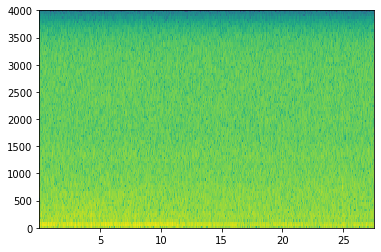

In [12]:
for i in range(11):
    x = graph_spectrogram('recorded_clips/fullbackgrounds_trimmed_5sec/{:0>2}.wav'.format(i))
    print(x.shape)

### make training dataset and save to disk

In [276]:
# load audio samples from disk
enoughs, notenoughs, empties, backgrounds = load_raw_audio()

enoughs:
backgrounds:
notenoughs:
empties:


sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7235: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


 14 15 16 17 18 19 20 21 22 23 24

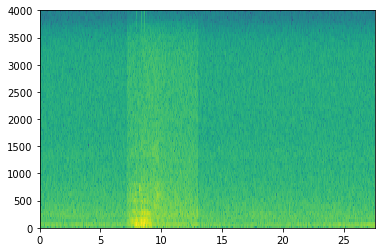

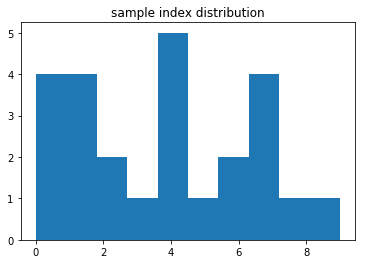

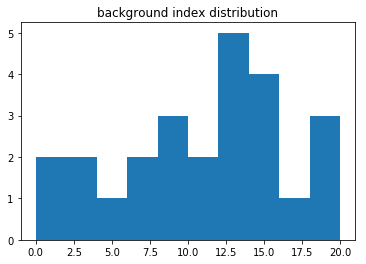

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24

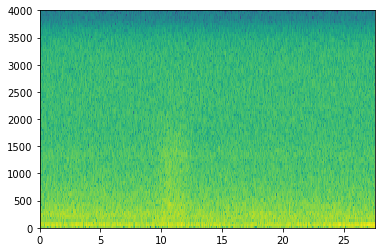

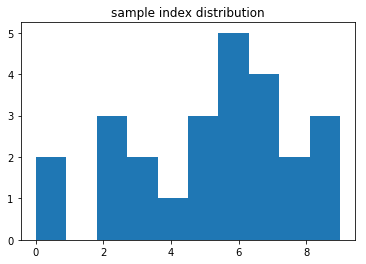

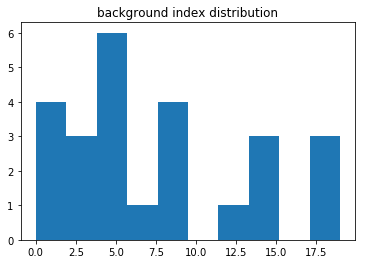

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49

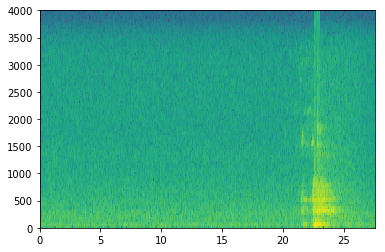

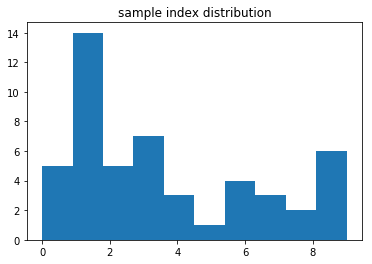

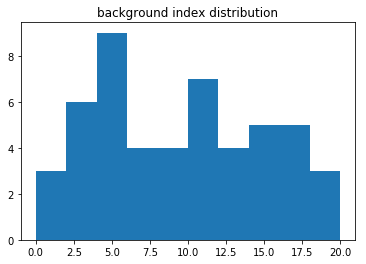

size of X:  (100, 2754, 101)
length of y: 100
Features saved to: XY_train/X_100_5sec.pkl
Labels saved to: XY_train/y_100_5sec.pkl


In [273]:
n_enoughs = 25
n_notenoughs = 25
n_empties = 50

X_training, y_training = make_training_data(n_enoughs, n_notenoughs, n_empties, Tx, n_freq, Ty)

save_datasets_to_disk(X_training, y_training, file_folder='XY_train', file_comment='100_5sec')

#### make smaller validation set

sample:  0 1 2 3

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7235: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


 4

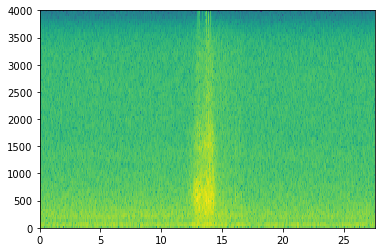

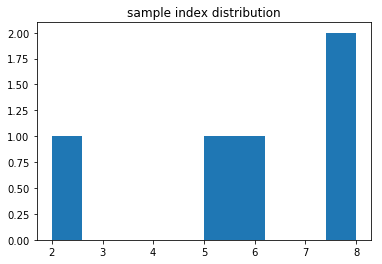

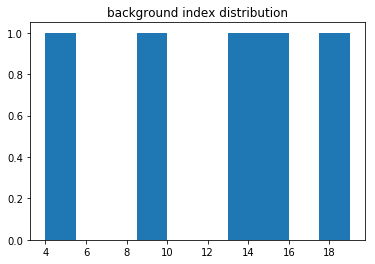

sample:  0 1 2 3 4

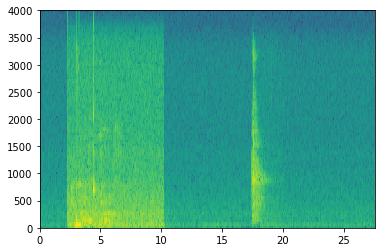

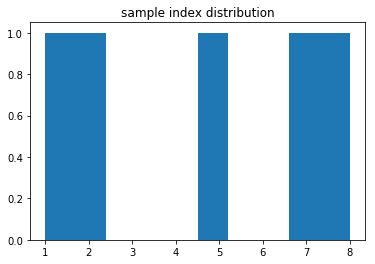

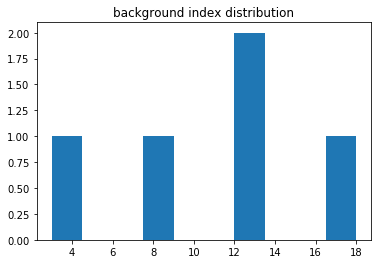

sample:  0 1 2 3 4 5 6 7 8 9

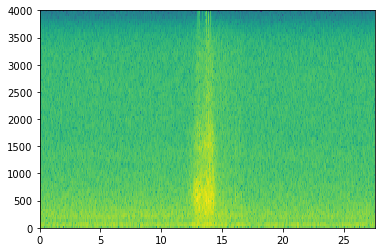

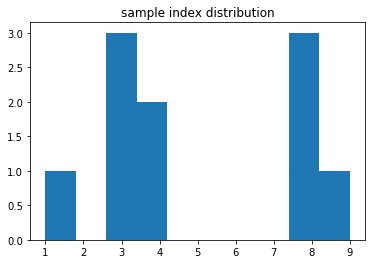

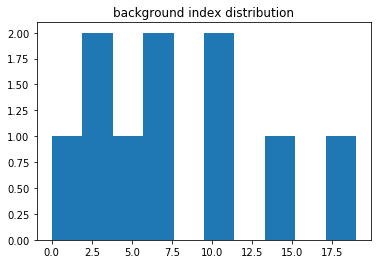

size of X:  (20, 2754, 101)
length of y: 20
Features saved to: XY_val/X_20_5sec.pkl
Labels saved to: XY_val/y_20_5sec.pkl


In [274]:
n_enoughs = 5
n_notenoughs = 5
n_empties = 10

X_val, y_val = make_training_data(n_enoughs, n_notenoughs, n_empties, Tx, n_freq, Ty)

save_datasets_to_disk(X_val, y_val, file_folder='XY_val', file_comment='20_5sec')